In [ ]:
# ========== CELL 1 ========== #
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import StratifiedKFold, train_test_split

In [ ]:
# ========== CELL 2 ========== #
# Load Data
digital_images = np.load("/content/drive/MyDrive/Thesis Model Data/Digital Image Data/filtered_digital_treated.npy")
thermal_images = np.load("/content/drive/MyDrive/Thesis Model Data/Thermal Image Data/preprocessed_thermal_treated_images.npy")
wound_labels = np.load("/content/drive/MyDrive/Thesis Model Data/Tabular Data/preprocessed_treated_labels.npy")
wound_sizes = np.load("/content/drive/MyDrive/Thesis Model Data/Tabular Data/preprocessed_treated_wound_sizes.npy")
metadata = np.load("/content/drive/MyDrive/Thesis Model Data/Tabular Data/preprocessed_treated_metadata.npy", allow_pickle=True)

In [ ]:
# ========== CELL 3 ========== #
# Reserve 10% of the data as a separate test set
train_idx, test_idx = train_test_split(np.arange(len(digital_images)), test_size=0.1, stratify=np.argmax(wound_labels, axis=1), random_state=42)

# Create training and testing sets
test_digital = digital_images[test_idx]
test_thermal = thermal_images[test_idx]
test_wound_sizes = wound_sizes[test_idx]
test_labels = wound_labels[test_idx]

# Use only the remaining 90% for cross-validation
cv_digital = digital_images[train_idx]
cv_thermal = thermal_images[train_idx]
cv_wound_sizes = wound_sizes[train_idx]
cv_labels = wound_labels[train_idx]

In [ ]:
# ========== CELL 4 ========== #
# Define the data augmentation layers
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
])

def augment_wound_size(wound_size):
    noise = tf.random.normal(shape=tf.shape(wound_size), mean=0.0, stddev=0.05)
    return wound_size + noise

In [ ]:
# ========== CELL 5 ========== #
# Define the CNN model for processing images
def build_cnn(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),  # Increased filters
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))
    ])
    return model

In [ ]:
# ========== CELL 6 ========== #
# Define Wound Size Processing

def build_wound_size_model():
    wound_size_input = keras.Input(shape=(1,), name="wound_size")
    wound_size_dense = layers.Dense(64, activation='relu')(wound_size_input)
    return wound_size_input, wound_size_dense

In [ ]:
# ========== CELL 7 ========== #
# Define Model Creation Function

def create_wtm_model():
    digital_input = keras.Input(shape=(224, 224, 3), name="digital_image")
    thermal_input = keras.Input(shape=(224, 224, 3), name="thermal_image")

    digital_cnn_model = build_cnn((224, 224, 3))
    digital_cnn = digital_cnn_model(digital_input)
    thermal_cnn_model = build_cnn((224, 224, 3))
    thermal_cnn = thermal_cnn_model(thermal_input)

    wound_size_input, wound_size_dense = build_wound_size_model()

    digital_features = digital_cnn
    thermal_features = thermal_cnn

    # Weighted feature processing
    weighted_digital = layers.Dense(512, activation='relu')(digital_features)  # Increase impact
    weighted_thermal = layers.Dense(128, activation='relu')(thermal_features)  # Reduce impact
    weighted_wound_size = layers.Dense(256, activation='relu')(wound_size_dense)  # Midway impact

    # Merge with learned weighting
    merged_features = layers.Concatenate()([weighted_digital, weighted_thermal, weighted_wound_size])

    x = layers.Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(merged_features)
    x = layers.Dropout(0.6)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.6)(x)
    output = layers.Dense(9, activation='softmax', name="classification_output")(x)

    model = keras.Model(inputs=[digital_input, thermal_input, wound_size_input], outputs=output)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss="categorical_crossentropy",
        metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="top_2_accuracy")]
    )

    return model

In [ ]:
# ========== CELL 8 ========== #
# Define K-Fold Cross-Validation

k_folds = 5
kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
fold_no = 1

all_histories = []

for train_idx, val_idx in kf.split(cv_digital, np.argmax(cv_labels, axis=1)):
    print(f"Training fold {fold_no}/{k_folds}...")

    train_digital, val_digital = digital_images[train_idx], digital_images[val_idx]
    train_thermal, val_thermal = thermal_images[train_idx], thermal_images[val_idx]
    train_wound_sizes, val_wound_sizes = wound_sizes[train_idx], wound_sizes[val_idx]
    train_labels, val_labels = wound_labels[train_idx], wound_labels[val_idx]

    model = create_wtm_model()

    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    checkpoint = keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Thesis Models/wtm_model_checkpoint_2.keras", monitor="val_loss", save_best_only=True, verbose=1)
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        [train_digital, train_thermal, train_wound_sizes], train_labels,
        epochs=50,
        batch_size=32,
        validation_data=([val_digital, val_thermal, val_wound_sizes], val_labels), callbacks=[early_stopping, reduce_lr, checkpoint]
    )

    all_histories.append(history)
    fold_no += 1

Training fold 1/5...
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.1170 - loss: 4.3512 - top_2_accuracy: 0.2268
Epoch 1: val_loss improved from inf to 3.53571, saving model to /content/drive/MyDrive/Thesis Models/wtm_model_checkpoint_2.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.1180 - loss: 4.3332 - top_2_accuracy: 0.2280 - val_accuracy: 0.1000 - val_loss: 3.5357 - val_top_2_accuracy: 0.3231 - learning_rate: 5.0000e-04
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.0942 - loss: 3.4960 - top_2_accuracy: 0.1849
Epoch 2: val_loss improved from 3.53571 to 3.14033, saving model to /content/drive/MyDrive/Thesis Models/wtm_model_checkpoint_2.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 580ms/step - accuracy: 0.0958 - loss: 3.4898 - top_2_accuracy: 0.1893 - val_accuracy: 0.1000 - val_loss: 3.1403 - val_top_2_accuracy: 0.2538 - learning_rate: 5.0000e-04
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.1440 - loss: 3.1270 - top_2_ac

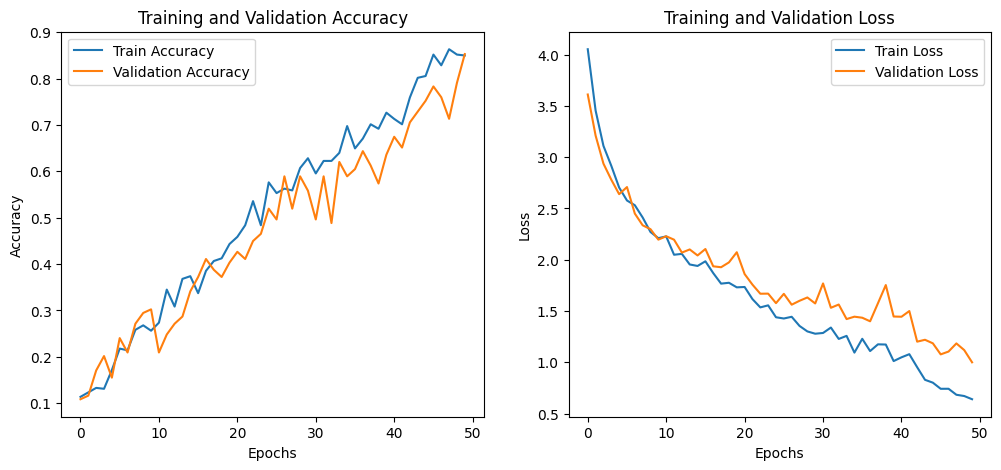

In [ ]:
# ========== CELL 9 ========== #
# Define function to plot training curves
def plot_training_curves(history):

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()
# Plot training curves for last fold

plot_training_curves(history)

In [ ]:
# ========== CELL 10 ========== #
# Print final training summary
print("Final Training Summary for All Folds:")
for i, hist in enumerate(all_histories):
    print(f"Fold {i+1} - Training Accuracy: {hist.history['accuracy'][-1]:.4f}, Validation Accuracy: {hist.history['val_accuracy'][-1]:.4f}")
    print(f"Fold {i+1} - Training Loss: {hist.history['loss'][-1]:.4f}, Validation Loss: {hist.history['val_loss'][-1]:.4f}")
print("Overall Performance:")
print(f"Final Training Accuracy (Last Fold): {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy (Last Fold): {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss (Last Fold): {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss (Last Fold): {history.history['val_loss'][-1]:.4f}")

Final Training Summary for All Folds:
Fold 1 - Training Accuracy: 0.8745, Validation Accuracy: 0.8615
Fold 1 - Training Loss: 0.6381, Validation Loss: 0.9611
Fold 2 - Training Accuracy: 0.9170, Validation Accuracy: 0.8154
Fold 2 - Training Loss: 0.5040, Validation Loss: 1.0535
Fold 3 - Training Accuracy: 0.8591, Validation Accuracy: 0.7308
Fold 3 - Training Loss: 0.7173, Validation Loss: 1.2511
Fold 4 - Training Accuracy: 0.8690, Validation Accuracy: 0.7829
Fold 4 - Training Loss: 0.6312, Validation Loss: 0.9001
Fold 5 - Training Accuracy: 0.8497, Validation Accuracy: 0.8527
Fold 5 - Training Loss: 0.6399, Validation Loss: 0.9998
Overall Performance:
Final Training Accuracy (Last Fold): 0.8497
Final Validation Accuracy (Last Fold): 0.8527
Final Training Loss (Last Fold): 0.6399
Final Validation Loss (Last Fold): 0.9998


In [ ]:
model.save('/content/drive/MyDrive/Thesis Models/WTM_V2.keras')

In [ ]:
# ========== CELL 11 ========== #
# Load the best trained model
best_model = keras.models.load_model("/content/drive/MyDrive/Thesis Models/wtm_model_checkpoint_2.keras")

In [ ]:
# ========== CELL 12 ========== #
# Evaluate on the independent test set
test_loss, test_accuracy, test_top2_accuracy = best_model.evaluate([test_digital, test_thermal, test_wound_sizes], test_labels)

print("Final Independent Test Performance:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Top-2 Accuracy: {test_top2_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8928 - loss: 1.4124 - top_2_accuracy: 0.8928
Final Independent Test Performance:
Test Accuracy: 0.9028
Test Top-2 Accuracy: 0.9028
Test Loss: 1.3278


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step


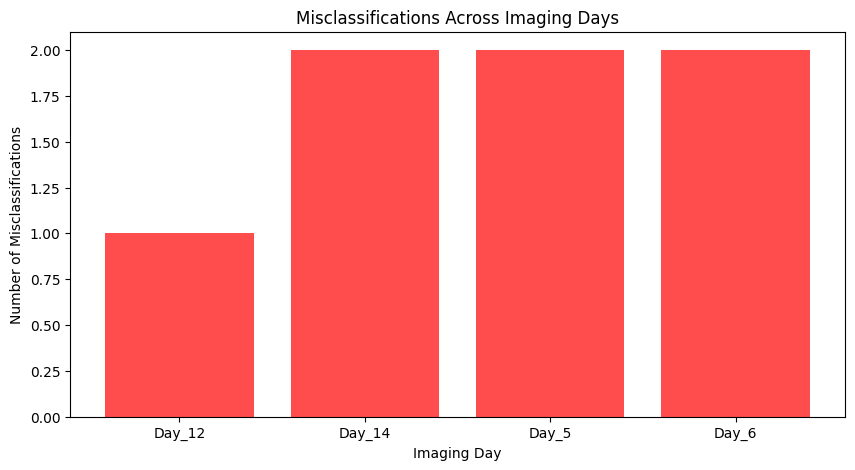

In [ ]:
# ========== CELL 13 ========== #
# Get predictions on the test set
test_predictions = best_model.predict([test_digital, test_thermal, test_wound_sizes])
predicted_classes = np.argmax(test_predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Find misclassified samples
misclassified_indices = np.where(predicted_classes != true_classes)[0]

# Extract imaging day from metadata
test_metadata = metadata[test_idx]  # Get the correct metadata for test samples
imaging_days = [test_metadata[i]['Imaging_Day'] for i in misclassified_indices]

# Count misclassifications per imaging day
unique_days, misclassification_counts = np.unique(imaging_days, return_counts=True)

# Plot the misclassification distribution across imaging days
plt.figure(figsize=(10, 5))
plt.bar(unique_days, misclassification_counts, color='red', alpha=0.7)
plt.xlabel("Imaging Day")
plt.ylabel("Number of Misclassifications")
plt.title("Misclassifications Across Imaging Days")
plt.xticks(unique_days)  # Ensure all imaging days are labeled
plt.show()

In [ ]:
# ========== CELL 14 ========== #
from collections import Counter

# Extract class labels from one-hot encoding
test_true_labels = np.argmax(test_labels, axis=1)

# Count the number of samples per class in the test set
test_class_counts = Counter(test_true_labels)

print("\nClass Distribution in Test Set:")
for cls, count in sorted(test_class_counts.items()):
    print(f"Class {cls}: {count} samples")


Class Distribution in Test Set:
Class 0: 8 samples
Class 1: 8 samples
Class 2: 8 samples
Class 3: 8 samples
Class 4: 8 samples
Class 5: 8 samples
Class 6: 8 samples
Class 7: 8 samples
Class 8: 8 samples


In [ ]:
# ========== CELL 15 ========== #
# Extract imaging days from metadata for the test set
test_metadata_subset = metadata[test_idx]
test_imaging_days = [entry['Imaging_Day'] for entry in test_metadata_subset]

# Count occurrences of each imaging day
unique_days, day_counts = np.unique(test_imaging_days, return_counts=True)

print("\nImaging Day Distribution in Test Set:")
for day, count in zip(unique_days, day_counts):
    print(f"Imaging Day {day}: {count} samples")


Imaging Day Distribution in Test Set:
Imaging Day Day_0: 10 samples
Imaging Day Day_10: 8 samples
Imaging Day Day_12: 13 samples
Imaging Day Day_14: 5 samples
Imaging Day Day_2: 7 samples
Imaging Day Day_5: 9 samples
Imaging Day Day_6: 12 samples
Imaging Day Day_8: 8 samples


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step


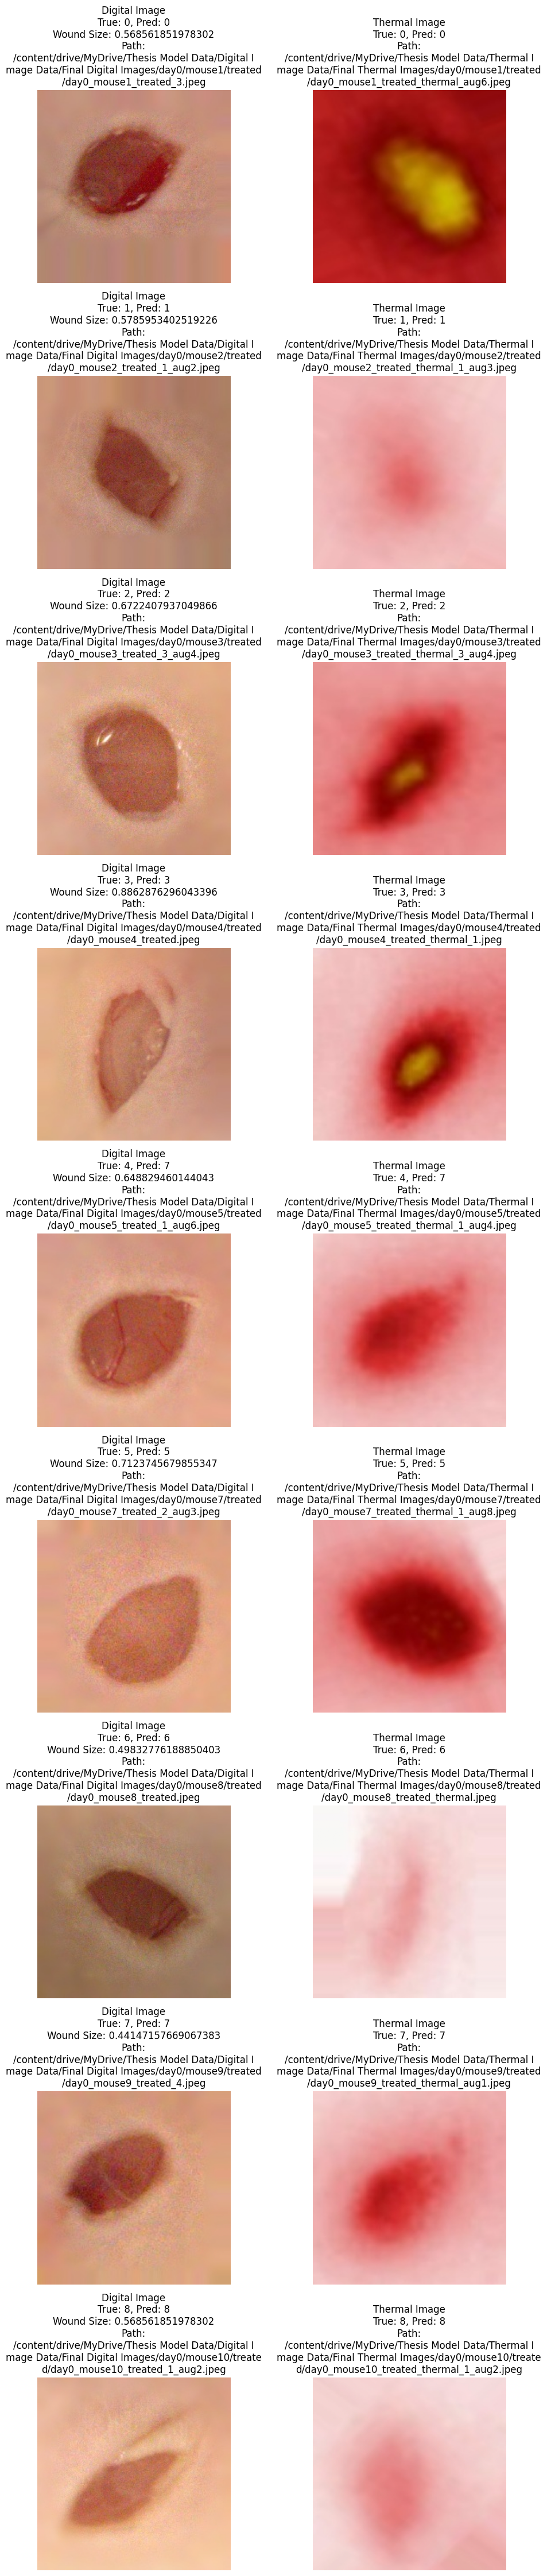

In [ ]:
# ========== CELL 16 ========== #
def display_predictions(model, val_digital, val_thermal, val_wound_sizes, val_labels, metadata, val_idx):
    predictions = model.predict([val_digital, val_thermal, val_wound_sizes])
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(val_labels, axis=1)

    unique_classes = np.unique(true_classes)
    fig, axes = plt.subplots(len(unique_classes), 2, figsize=(10, 5 * len(unique_classes)))

    for i, cls in enumerate(unique_classes):
        idx = np.where(true_classes == cls)[0][0]  # Get the first occurrence of each class

        # Use val_idx to get the original metadata index
        original_idx = val_idx[idx]

        digital_image = val_digital[idx]
        thermal_image = val_thermal[idx].squeeze()
        wound_size = val_wound_sizes[idx][0]
        true_label = cls
        predicted_label = predicted_classes[idx]

        digital_path = metadata[original_idx]['Digital_Image_Path']
        thermal_path = metadata[original_idx]['Thermal_Image_Path']

        # Split paths into multiple rows
        digital_path_split = "\n".join([digital_path[j:j+50] for j in range(0, len(digital_path), 50)])
        thermal_path_split = "\n".join([thermal_path[j:j+50] for j in range(0, len(thermal_path), 50)])

        axes[i, 0].imshow(digital_image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Digital Image\nTrue: {true_label}, Pred: {predicted_label}\n"
                             f"Wound Size: {wound_size}\nPath:\n{digital_path_split}")

        axes[i, 1].imshow(thermal_image, cmap='hot')
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Thermal Image\nTrue: {true_label}, Pred: {predicted_label}\nPath:\n{thermal_path_split}")

    plt.tight_layout()
    plt.show()

# Call with val_idx to align metadata correctly
display_predictions(model, val_digital, val_thermal, val_wound_sizes, val_labels, metadata, val_idx)